# Импорт библиотек

In [6]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import torch
import torchvision.transforms as transforms

from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from numpy.random import rand
from PIL import Image
from scipy.stats import mannwhitneyu, spearmanr
from sentence_transformers import SentenceTransformer, util
from torchmetrics.multimodal.clip_score import CLIPScore
from transformers import BlipForConditionalGeneration, BlipProcessor, pipeline
from tqdm import tqdm

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('tagsets')
nltk.download('wordnet')

# Датасет

Датасет был загружен с сайта huggingface (https://huggingface.co/datasets/poloclub/diffusiondb/tree/main). Изначально он содержал 2 млн промптов в паре с изображениями, однако для анализа была взята случайная выборка из 100.000 промптов.

In [236]:
df = pd.read_parquet('content/metadata.parquet')

df.head()

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:56:00+00:00,0.554853,0.001621
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,2022-08-20 07:22:00+00:00,0.030799,0.003586
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822


In [237]:
df = df[df['part_id'] < 101]

In [238]:
len(df)

100000

In [239]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:56:00+00:00,0.554853,0.001621
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,2022-08-20 07:22:00+00:00,0.030799,0.003586
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:37:00+00:00,0.229731,0.002274
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:44:00+00:00,0.080147,0.000995
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:49:00+00:00,0.111912,0.020084
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:53:00+00:00,0.639888,0.001248


# Метрики качества изображений

Прежде всего были посчитаны метрики качества изображений: CLIP-score, BLIP-ITM-score и BLIP-ITC-score

* CLIP-score: https://torchmetrics.readthedocs.io/en/v1.2.0/multimodal/clip_score.html
* BLIP-ITM-score, BLIP-ITC-score - метрики, посчитанные с помощью модели BLIP-2: https://huggingface.co/docs/transformers/model_doc/blip-2
* Все эти метрики считают качество изображения, исходя из промпта (т.е. насколько изображение соответствует промпту)

In [7]:
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to('cuda')

C:\Users\mozg2\PycharmProjects\deepML\venv\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
model, vis_processors, text_processors = load_model_and_preprocess("blip2_image_text_matching", "pretrain", device='cuda', is_eval=True)

In [8]:
transform = transforms.Compose([
    transforms.PILToTensor()
])

In [10]:
clip_scores = []
blip_itc_scores = []
blip_itm_scores = []

In [11]:
for i in tqdm(range(50000, len(df)+50000)):
  if len(str(df['part_id'][i])) == 1:
    part = 'part-00000'
  elif len(str(df['part_id'][i])) == 2:
    part = 'part-0000'
  else:
    part = 'part-000'
  image = Image.open('content/' + part + str(df['part_id'][i]) + '/' + df['image_name'][i])
  prompt = df['prompt'][i]
  #clip preproc
  img_tensor = transform(image).to('cuda')
  #clip score
  score = metric(img_tensor, prompt)
  clip_scores.append(score.detach().cpu().numpy())
  #blip preproc
  img = vis_processors["eval"](image).unsqueeze(0).to('cuda')
  txt = text_processors["eval"](prompt)
  #itc score
  itc_score = model({"image": img, "text_input": txt}, match_head='itc')
  blip_itc_scores.append(itc_score[:, 0].item())
  #itm score
  itm_output = model({"image": img, "text_input": txt}, match_head="itm")
  itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
  blip_itm_scores.append(itm_scores[:, 1].item())

  0%|▎                                                                                                                                                                                                        | 88/50000 [00:56<8:28:53,  1.63it/s]C:\Users\mozg2\PycharmProjects\deepML\venv\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered caption longer than max_position_embeddings=77. Will truncate captions to this length.If longer captions are needed, initialize argument `model_name_or_path` with a model that supportslonger sequences
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [8:37:36<00:00,  1.61it/s]


In [12]:
df['clip_score'] = clip_scores
df['itm_score'] = blip_itm_scores
df['itc_score'] = blip_itc_scores

In [17]:
df.clip_score = df.clip_score.astype(float)

In [28]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,clip_score,itm_score,itc_score
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:56:00+00:00,0.554853,0.001621,33.170734,0.999407,0.433172
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707,35.475933,0.720704,0.406369
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425,28.985870,0.924845,0.383907
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,2022-08-20 07:22:00+00:00,0.030799,0.003586,30.475240,0.079445,0.343708
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822,41.676163,0.999895,0.443519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:37:00+00:00,0.229731,0.002274,28.474754,0.851479,0.368925
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:44:00+00:00,0.080147,0.000995,33.381813,0.999951,0.508449
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:49:00+00:00,0.111912,0.020084,31.739086,0.998676,0.407689
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:53:00+00:00,0.639888,0.001248,37.644215,0.999952,0.485627


# Лингвистические особенности

## Количественная информация

Первым шагом по выявлению лингвистических особенностей промптов стал подсчет:
* средней длины слова в промпте;
* общего количества слов в промпте;
* количества токенов в промпте;
* среднего количества слов в токене.

In [10]:
tokenizer = RegexpTokenizer(r'\w+')

In [31]:
len_of_word = []
words_count = []
tokens_count = []
words_count_in_token = []

In [32]:
for i in tqdm(range(len(df))):
    text = df['prompt'][i]
    word_tokens = tokenizer.tokenize(text)
    if len(word_tokens) != 0:
        lens = [len(word.strip()) for word in word_tokens]
        len_of_word.append(sum(lens)/len(lens))
    else:
        len_of_word.append(0)
    words_count.append(len(word_tokens))
    word_tokens = text.split(sep=', ')
    tokens_count.append(len(word_tokens))
    if len(word_tokens) > 1:
        lens = [len(tokenizer.tokenize(token)) for token in word_tokens]
        words_count_in_token.append(sum(lens)/len(lens))
    elif len(word_tokens) == 1:
        words_count_in_token.append(len(tokenizer.tokenize(word_tokens[0])))
    else:
        words_count_in_token.append(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39446.08it/s]


In [33]:
df['len_of_word'] = len_of_word
df['words_count'] = words_count
df['tokens_count'] = tokens_count
df['words_count_in_token'] = words_count_in_token

In [34]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,clip_score,itm_score,itc_score,len_of_word,words_count,tokens_count,words_count_in_token
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:56:00+00:00,0.554853,0.001621,33.170734,0.999407,0.433172,4.684211,19,5,3.8
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707,35.475933,0.720704,0.406369,4.900000,30,6,5.0
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425,28.985870,0.924845,0.383907,6.333333,6,2,3.0
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,2022-08-20 07:22:00+00:00,0.030799,0.003586,30.475240,0.079445,0.343708,5.400000,5,1,5.0
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822,41.676163,0.999895,0.443519,4.428571,7,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:37:00+00:00,0.229731,0.002274,28.474754,0.851479,0.368925,5.600000,35,1,35.0
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:44:00+00:00,0.080147,0.000995,33.381813,0.999951,0.508449,5.266667,30,1,30.0
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:49:00+00:00,0.111912,0.020084,31.739086,0.998676,0.407689,5.166667,42,1,42.0
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 06:53:00+00:00,0.639888,0.001248,37.644215,0.999952,0.485627,5.358974,39,1,39.0


## Падежная разметка

Далее была посчитана частота каждой части речи в промптах при помощи библиотеки nltk

In [38]:
tagdict = nltk.data.load('help/tagsets/upenn_tagset.pickle')

In [39]:
pos_count_overall = []

In [40]:
for i in tqdm(range(len(df))):
    text = df['prompt'][i]
    word_tokens = tokenizer.tokenize(text)
    pos_tags = pos_tag(word_tokens)
    tag_count = dict(zip(sorted(tagdict.keys())[8:-1], [0] * len(sorted(tagdict.keys())[8:-1])))
    for word, tag in pos_tags:
        if tag in tag_count.keys():
            tag_count[tag] += 1
    pos_count_overall.append(tag_count)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:32<00:00, 1085.23it/s]


In [41]:
for key in pos_count_overall[0].keys():
    df[key] = [0] * 100000

In [42]:
for i in tqdm(range(len(pos_count_overall))):
    for key in pos_count_overall[i].keys():
        df[key][i] = pos_count_overall[i][key]

  0%|                                                                                                                                                                                                                   | 0/100000 [00:00<?, ?it/s]C:\Users\mozg2\AppData\Local\Temp\ipykernel_752\1421614901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key][i] = pos_count_overall[i][key]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:09<00:00, 323.54it/s]


In [43]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,1,1,0,0,0,0,0,0
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,2,1,0,0,0,0,0,0
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,1,0,1,0,0,0,0,0
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,...,0,0,1,0,0,0,0,0,0,0
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,1,0,0,0,0,0,0,0,0
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,1,1,0,0,0,0,0
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,1,0,2,1,0,0,0,0,0
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,1,0,2,1,0,0,0,0,0


# Стилеметрические индексы

Далее были посчитаны стилеметрические индексы (формулы приведены в тексте ВКР):
* индекс предметности;
* индекс качественнсти;
* индекс активности;
* индекс динамизма;
* индекс связанности.

In [44]:
subject_index = []
quality_index = []
activity_index = []
dynamism_index = []
connectivity_index = []

In [45]:
for i in tqdm(range(len(df))):
    if df['tokens_count'][i] != 0:
        connectivity_index.append((df['IN'][i] + df['CC'][i]) / df['tokens_count'][i])
    else:
        connectivity_index.append(0)
    if (df['NN'][i] + df['NNP'][i] + df['NNS'][i] + df['NNPS'][i] + df['JJ'][i] + df['JJR'][i] + df['JJS'][i] + df['PRP'][i] + df['PRP$'][i] + df['WP'][i] + df['WP$'][i]) != 0:
        dynamism_index.append((df['VB'][i] + df['VBD'][i] + df['VBG'][i] + df['VBN'][i]) / (df['NN'][i] + df['NNP'][i] + df['NNS'][i] + df['NNPS'][i] + df['JJ'][i] + df['JJR'][i] + df['JJS'][i] + df['PRP'][i] + df['PRP$'][i] + df['WP'][i] + df['WP$'][i]))
    else:
        dynamism_index.append(0)
    if df['words_count'][i] != 0:
        activity_index.append((df['VB'][i] + df['VBD'][i] + df['VBG'][i] + df['VBN'][i]) / df['words_count'][i])
    else:
        activity_index.append(0)
    if (df['NN'][i] + df['NNP'][i] + df['NNS'][i] + df['NNPS'][i] + df['VB'][i] + df['VBD'][i] + df['VBG'][i] + df['VBN'][i]) != 0:
        quality_index.append((df['JJ'][i] + df['JJR'][i] + df['JJS'][i] + df['RB'][i] + df['RBR'][i] + df['RBS'][i]) / (df['NN'][i] + df['NNP'][i] + df['NNS'][i] + df['NNPS'][i] + df['VB'][i] + df['VBD'][i] + df['VBG'][i] + df['VBN'][i]))
    else:
        quality_index.append(0)
    if (df['VB'][i] + df['VBD'][i] + df['VBG'][i] + df['VBN'][i] + df['JJ'][i] + df['JJR'][i] + df['JJS'][i]) != 0:
        subject_index.append((df['NN'][i] + df['NNP'][i] + df['NNS'][i] + df['NNPS'][i] + df['PRP'][i] + df['PRP$'][i] + df['WP'][i] + df['WP$'][i]) / (df['VB'][i] + df['VBD'][i] + df['VBG'][i] + df['VBN'][i] + df['JJ'][i] + df['JJR'][i] + df['JJS'][i]))
    else:
        subject_index.append(0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:35<00:00, 2792.14it/s]


In [46]:
df['subject_index'] = subject_index
df['quality_index'] = quality_index
df['activity_index'] = activity_index
df['dynamism_index'] = dynamism_index
df['connectivity_index'] = connectivity_index

In [3]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,...,VBZ,WDT,WP,WP$,WRB,subject_index,quality_index,activity_index,dynamism_index,connectivity_index
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,0,0,0,1.000000,0.625000,0.105263,0.200000,0.600000
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,0,0,0,1.571429,0.428571,0.100000,0.200000,0.666667
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,0,0,0,2.000000,0.333333,0.166667,0.500000,0.500000
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,...,0,0,0,0,0,3.000000,0.000000,0.200000,0.333333,1.000000
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,...,0,0,0,0,0,4.000000,0.000000,0.142857,0.250000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,0,0,3.666667,0.260870,0.028571,0.037037,1.000000
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,0,0,3.400000,0.277778,0.033333,0.047619,2.000000
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,0,0,3.000000,0.259259,0.071429,0.103448,2.000000
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,0,0,2.875000,0.269231,0.076923,0.107143,1.000000


## Индексы Флеша-Кинкейда и туманности Ганнинга

Далее были посчитаны индексы Флеша-Кинкейда и туманности Ганнинга (формулы приведены в тексте ВКР)

In [7]:
def count_vowels(word):
    c = 0
    for letter in word.lower():
        if letter in 'aeiou':
            c += 1
    return c

In [30]:
fk_index = []
fog_index = []

In [31]:
for i in tqdm(range(len(df))):
    text = df['prompt'][i]
    word_tokens = tokenizer.tokenize(text)
    if len(word_tokens) != 0:
        syl_count_avg = 0
        complex_words_count = 0
        for word in word_tokens:
            syl_count_avg += count_vowels(word)
            if count_vowels(word) >= 3:
                complex_words_count += 1
        syl_count_avg = syl_count_avg / df['words_count'][i]
        fk_index.append(max([206.835 - 1.015 * df['words_count'][i] - 84.6 * syl_count_avg, 0]))
        fog_index.append(0.4 * (df['words_count'][i] + 100 * complex_words_count / df['words_count'][i]))
    else:
        fk_index.append(0)
        fog_index.append(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 17434.34it/s]


In [32]:
df['fog_index'] = fog_index
df['fk_index'] = fk_index

In [33]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,...,WP,WP$,WRB,subject_index,quality_index,activity_index,dynamism_index,connectivity_index,fog_index,fk_index
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,0,1.000000,0.625000,0.105263,0.200000,0.600000,20.231579,27.255263
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,0,1.571429,0.428571,0.100000,0.200000,0.666667,26.666667,10.005000
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,0,2.000000,0.333333,0.166667,0.500000,0.500000,22.400000,0.000000
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,...,0,0,0,3.000000,0.000000,0.200000,0.333333,1.000000,2.000000,49.480000
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,...,0,0,0,4.000000,0.000000,0.142857,0.250000,0.000000,8.514286,42.615714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,3.666667,0.260870,0.028571,0.037037,1.000000,32.285714,0.000000
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,3.400000,0.277778,0.033333,0.047619,2.000000,28.000000,12.825000
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,3.000000,0.259259,0.071429,0.103448,2.000000,31.085714,5.076429
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,0,2.875000,0.269231,0.076923,0.107143,1.000000,30.984615,4.557692


# Коэффициент лексического разнообразия

Далее был посчитан коэффициент лексического разнообразия

In [40]:
lemmatizer = WordNetLemmatizer()

In [46]:
lex_divers_index = []

In [47]:
for i in tqdm(range(len(df))):
    text = df['prompt'][i]
    word_tokens = tokenizer.tokenize(text)
    if len(word_tokens) != 0:
        words = []
        for word in word_tokens:
            words.append(lemmatizer.lemmatize(word))
        lex_divers_index.append(len(list(set(words)))/df['words_count'][i])
    else:
        lex_divers_index.append(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9806.70it/s]


In [48]:
df['lex_divers_index'] = lex_divers_index

In [52]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,...,WP$,WRB,subject_index,quality_index,activity_index,dynamism_index,connectivity_index,fog_index,fk_index,lex_divers_index
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,1.000000,0.625000,0.105263,0.200000,0.600000,20.231579,27.255263,0.947368
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,1.571429,0.428571,0.100000,0.200000,0.666667,26.666667,10.005000,0.866667
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,0,2.000000,0.333333,0.166667,0.500000,0.500000,22.400000,0.000000,1.000000
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,...,0,0,3.000000,0.000000,0.200000,0.333333,1.000000,2.000000,49.480000,1.000000
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,...,0,0,4.000000,0.000000,0.142857,0.250000,0.000000,8.514286,42.615714,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,3.666667,0.260870,0.028571,0.037037,1.000000,32.285714,0.000000,0.971429
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,3.400000,0.277778,0.033333,0.047619,2.000000,28.000000,12.825000,0.966667
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,3.000000,0.259259,0.071429,0.103448,2.000000,31.085714,5.076429,0.880952
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,0,2.875000,0.269231,0.076923,0.107143,1.000000,30.984615,4.557692,0.897436


# Извлечение текстового описания картинки

При помощи модели https://huggingface.co/Salesforce/blip-image-captioning-base было извлечено текстовое описание картинки

In [54]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

C:\Users\mozg2\PycharmProjects\deepML\venv\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

C:\Users\mozg2\PycharmProjects\deepML\venv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mozg2\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [60]:
img_text = []

In [61]:
for i in tqdm(range(len(df))):
    if len(str(df['part_id'][i])) == 1:
        part = 'part-00000'
    elif len(str(df['part_id'][i])) == 2:
        part = 'part-0000'
    else:
        part = 'part-000'
    image = Image.open('content/' + part + str(df['part_id'][i]) + '/' + df['image_name'][i])
    prompt = df['prompt'][i]
    text = "a photography of"
    inputs = processor(image, text, return_tensors="pt").to("cuda")
    out = model.generate(**inputs)
    img_text.append(processor.decode(out[0], skip_special_tokens=True))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [6:31:34<00:00,  4.26it/s]


In [62]:
df['img_text'] = img_text

In [5]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,...,WRB,subject_index,quality_index,activity_index,dynamism_index,connectivity_index,fog_index,fk_index,lex_divers_index,img_text
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,1.000000,0.625000,0.105263,0.200000,0.600000,20.231579,27.255263,0.947368,a photography of a robot woman
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,1.571429,0.428571,0.100000,0.200000,0.666667,26.666667,10.005000,0.866667,a photography of a woman with a robot head
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0,2.000000,0.333333,0.166667,0.500000,0.500000,22.400000,0.000000,1.000000,"a photography of a man walking in a dark, myst..."
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,...,0,3.000000,0.000000,0.200000,0.333333,1.000000,2.000000,49.480000,1.000000,a photography of a pool
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,...,0,4.000000,0.000000,0.142857,0.250000,0.000000,8.514286,42.615714,1.000000,a photography of a dog lifting a dumbble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,3.666667,0.260870,0.028571,0.037037,1.000000,32.285714,0.000000,0.971429,a photography of a young man with a serious ex...
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,3.400000,0.277778,0.033333,0.047619,2.000000,28.000000,12.825000,0.966667,a photography of a woman with long brown hair ...
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,3.000000,0.259259,0.071429,0.103448,2.000000,31.085714,5.076429,0.880952,a photography of a man with a beard
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0,2.875000,0.269231,0.076923,0.107143,1.000000,30.984615,4.557692,0.897436,a photography of a man with a beard and a beard


# Косинусная мера сходства семантических векторов

Далее была посчитана косинусная мера сходства семантических векторов

Для начала промпты и текстовые описания картинок были преобразованы в семантические векторы при помощи модели https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [10]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [28]:
prompts = list(df['prompt'])
img_texts = list(df['img_text'])

In [29]:
img_text_embd = model.encode(img_texts)
prompt_embd = model.encode(prompts)

Затем при помощи функции pytorch_cos_sim библиотеки sentence_transformers была посчитана косинусная мера сходства промптов и текстовых описаний картинок (для каждой пары)

In [30]:
embd_similarity = []

In [31]:
for i in tqdm(range(len(df))):
    embd_similarity.append(util.pytorch_cos_sim(prompt_embd[i], img_text_embd[i]).item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10480.49it/s]


In [33]:
df['embd_similarity'] = embd_similarity

# Анализ синтаксической структуры промптов

При помощи библиотеки spacy была проанализирована синтаксическая структура промптов

In [ ]:
nlp=spacy.load('en_core_web_sm')

В ячейке ниже продемонстрирована схема зависимостей, построенная для отдельно взятого промпта

In [47]:
text=df['prompt'][14]

print(f"{'Token':{8}} {'dependence':{6}} {'head text':{9}}  {'Dependency explained'} ")
for token in nlp(text):
     print(f"{token.text:{8}} {token.dep_+' =>':{10}}   {token.head.text:{9}}  {spacy.explain(token.dep_)} ")

Token    dependence head text  Dependency explained 
an       det =>       painting   determiner 
emo      compound =>   portrait   compound 
portrait compound =>   painting   compound 
painting ROOT =>      painting   root 
.        punct =>     painting   punctuation 
short    amod =>      haircut    adjectival modifier 
dark     amod =>      brown      adjectival modifier 
brown    amod =>      haircut    adjectival modifier 
messy    amod =>      haircut    adjectival modifier 
pixie    compound =>   haircut    compound 
haircut  ROOT =>      haircut    root 
,        punct =>     haircut    punctuation 
large    amod =>      eyes       adjectival modifier 
black    amod =>      eyes       adjectival modifier 
eyes     appos =>     haircut    appositional modifier 
,        punct =>     haircut    punctuation 
antichrist compound =>   eyes       compound 
eyes     appos =>     haircut    appositional modifier 
,        punct =>     eyes       punctuation 
slightly advmod =>    roun

Далее идет подсчет количества основ в каждом промпте

In [53]:
root_count = []

In [54]:
for i in tqdm(range(len(df))):
    text=df['prompt'][i]
    dep_str = []
    for token in nlp(text):
         dep_str.append(token.dep_)
    if dep_str.count('ROOT'):
        root_count.append(dep_str.count('ROOT'))
    else:
        root_count.append(0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [10:37<00:00, 156.97it/s]


In [56]:
df['root_count'] = root_count

In [59]:
df

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,...,quality_index,activity_index,dynamism_index,connectivity_index,fog_index,fk_index,lex_divers_index,img_text,embd_similarity,root_count
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0.625000,0.105263,0.200000,0.600000,20.231579,27.255263,0.947368,a photography of a robot woman,0.668961,1
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0.428571,0.100000,0.200000,0.666667,26.666667,10.005000,0.866667,a photography of a woman with a robot head,0.639579,1
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,...,0.333333,0.166667,0.500000,0.500000,22.400000,0.000000,1.000000,"a photography of a man walking in a dark, myst...",0.047936,1
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,...,0.000000,0.200000,0.333333,1.000000,2.000000,49.480000,1.000000,a photography of a pool,0.496812,1
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,...,0.000000,0.142857,0.250000,0.000000,8.514286,42.615714,1.000000,a photography of a dog lifting a dumbble,0.527209,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,f091c225-1451-4161-80b2-e4c956c183e9.png,hyperrealistic portrait of a handsome male hea...,100,1379276895,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0.260870,0.028571,0.037037,1.000000,32.285714,0.000000,0.971429,a photography of a young man with a serious ex...,0.524907,1
99996,425e532c-1c67-47f8-b758-58cf3fee1bb3.png,hyperdetailed portrait of elizabeth olsen as s...,100,4194905603,50,9.0,8,640,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0.277778,0.033333,0.047619,2.000000,28.000000,12.825000,0.966667,a photography of a woman with long brown hair ...,0.427685,1
99997,839fcf92-1c2e-4a22-affd-7510b70b6bde.png,hyperdetailed portrait of henry cavill as a ma...,100,1639252212,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0.259259,0.071429,0.103448,2.000000,31.085714,5.076429,0.880952,a photography of a man with a beard,0.353718,2
99998,09019207-7eb2-408c-a30b-c6c028e424a6.png,hyperdetailed portrait of chris evans rugged r...,100,1488736428,50,9.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,...,0.269231,0.076923,0.107143,1.000000,30.984615,4.557692,0.897436,a photography of a man with a beard and a beard,0.406954,2


# Корреляции

Далее были выявлены корреляции между метриками качества и лингвистическими особенностями промптов

In [61]:
df.columns

Index(['image_name', 'prompt', 'part_id', 'seed', 'step', 'cfg', 'sampler',
       'width', 'height', 'user_name', 'timestamp', 'image_nsfw',
       'prompt_nsfw', 'clip_score', 'itm_score', 'itc_score', 'len_of_word',
       'words_count', 'tokens_count', 'words_count_in_token', 'CC', 'CD', 'DT',
       'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
       'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
       'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$',
       'WRB', 'subject_index', 'quality_index', 'activity_index',
       'dynamism_index', 'connectivity_index', 'fog_index', 'fk_index',
       'lex_divers_index', 'img_text', 'embd_similarity', 'root_count'],
      dtype='object')

In [63]:
correlation_matrix = df[['clip_score', 'itm_score', 'itc_score', 'len_of_word',
       'words_count', 'tokens_count', 'words_count_in_token', 'CC', 'CD', 'DT',
       'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
       'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
       'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$',
       'WRB', 'subject_index', 'quality_index', 'activity_index',
       'dynamism_index', 'connectivity_index', 'fog_index', 'fk_index',
       'lex_divers_index', 'embd_similarity', 'root_count']].corr()

In [64]:
correlation_matrix[['clip_score', 'itm_score', 'itc_score']]

,clip_score,itm_score,itc_score
clip_score,1.000000,0.313790,0.335704
itm_score,0.313790,1.000000,0.717568
itc_score,0.335704,0.717568,1.000000
len_of_word,-0.034469,-0.003976,0.010708
words_count,-0.266843,-0.085302,-0.036596
tokens_count,-0.256657,-0.045603,0.015311
words_count_in_token,0.056008,0.020228,-0.004243
CC,-0.133126,-0.052747,-0.050325
CD,-0.108164,-0.013223,-0.029273
DT,-0.025170,-0.079082,-0.066977


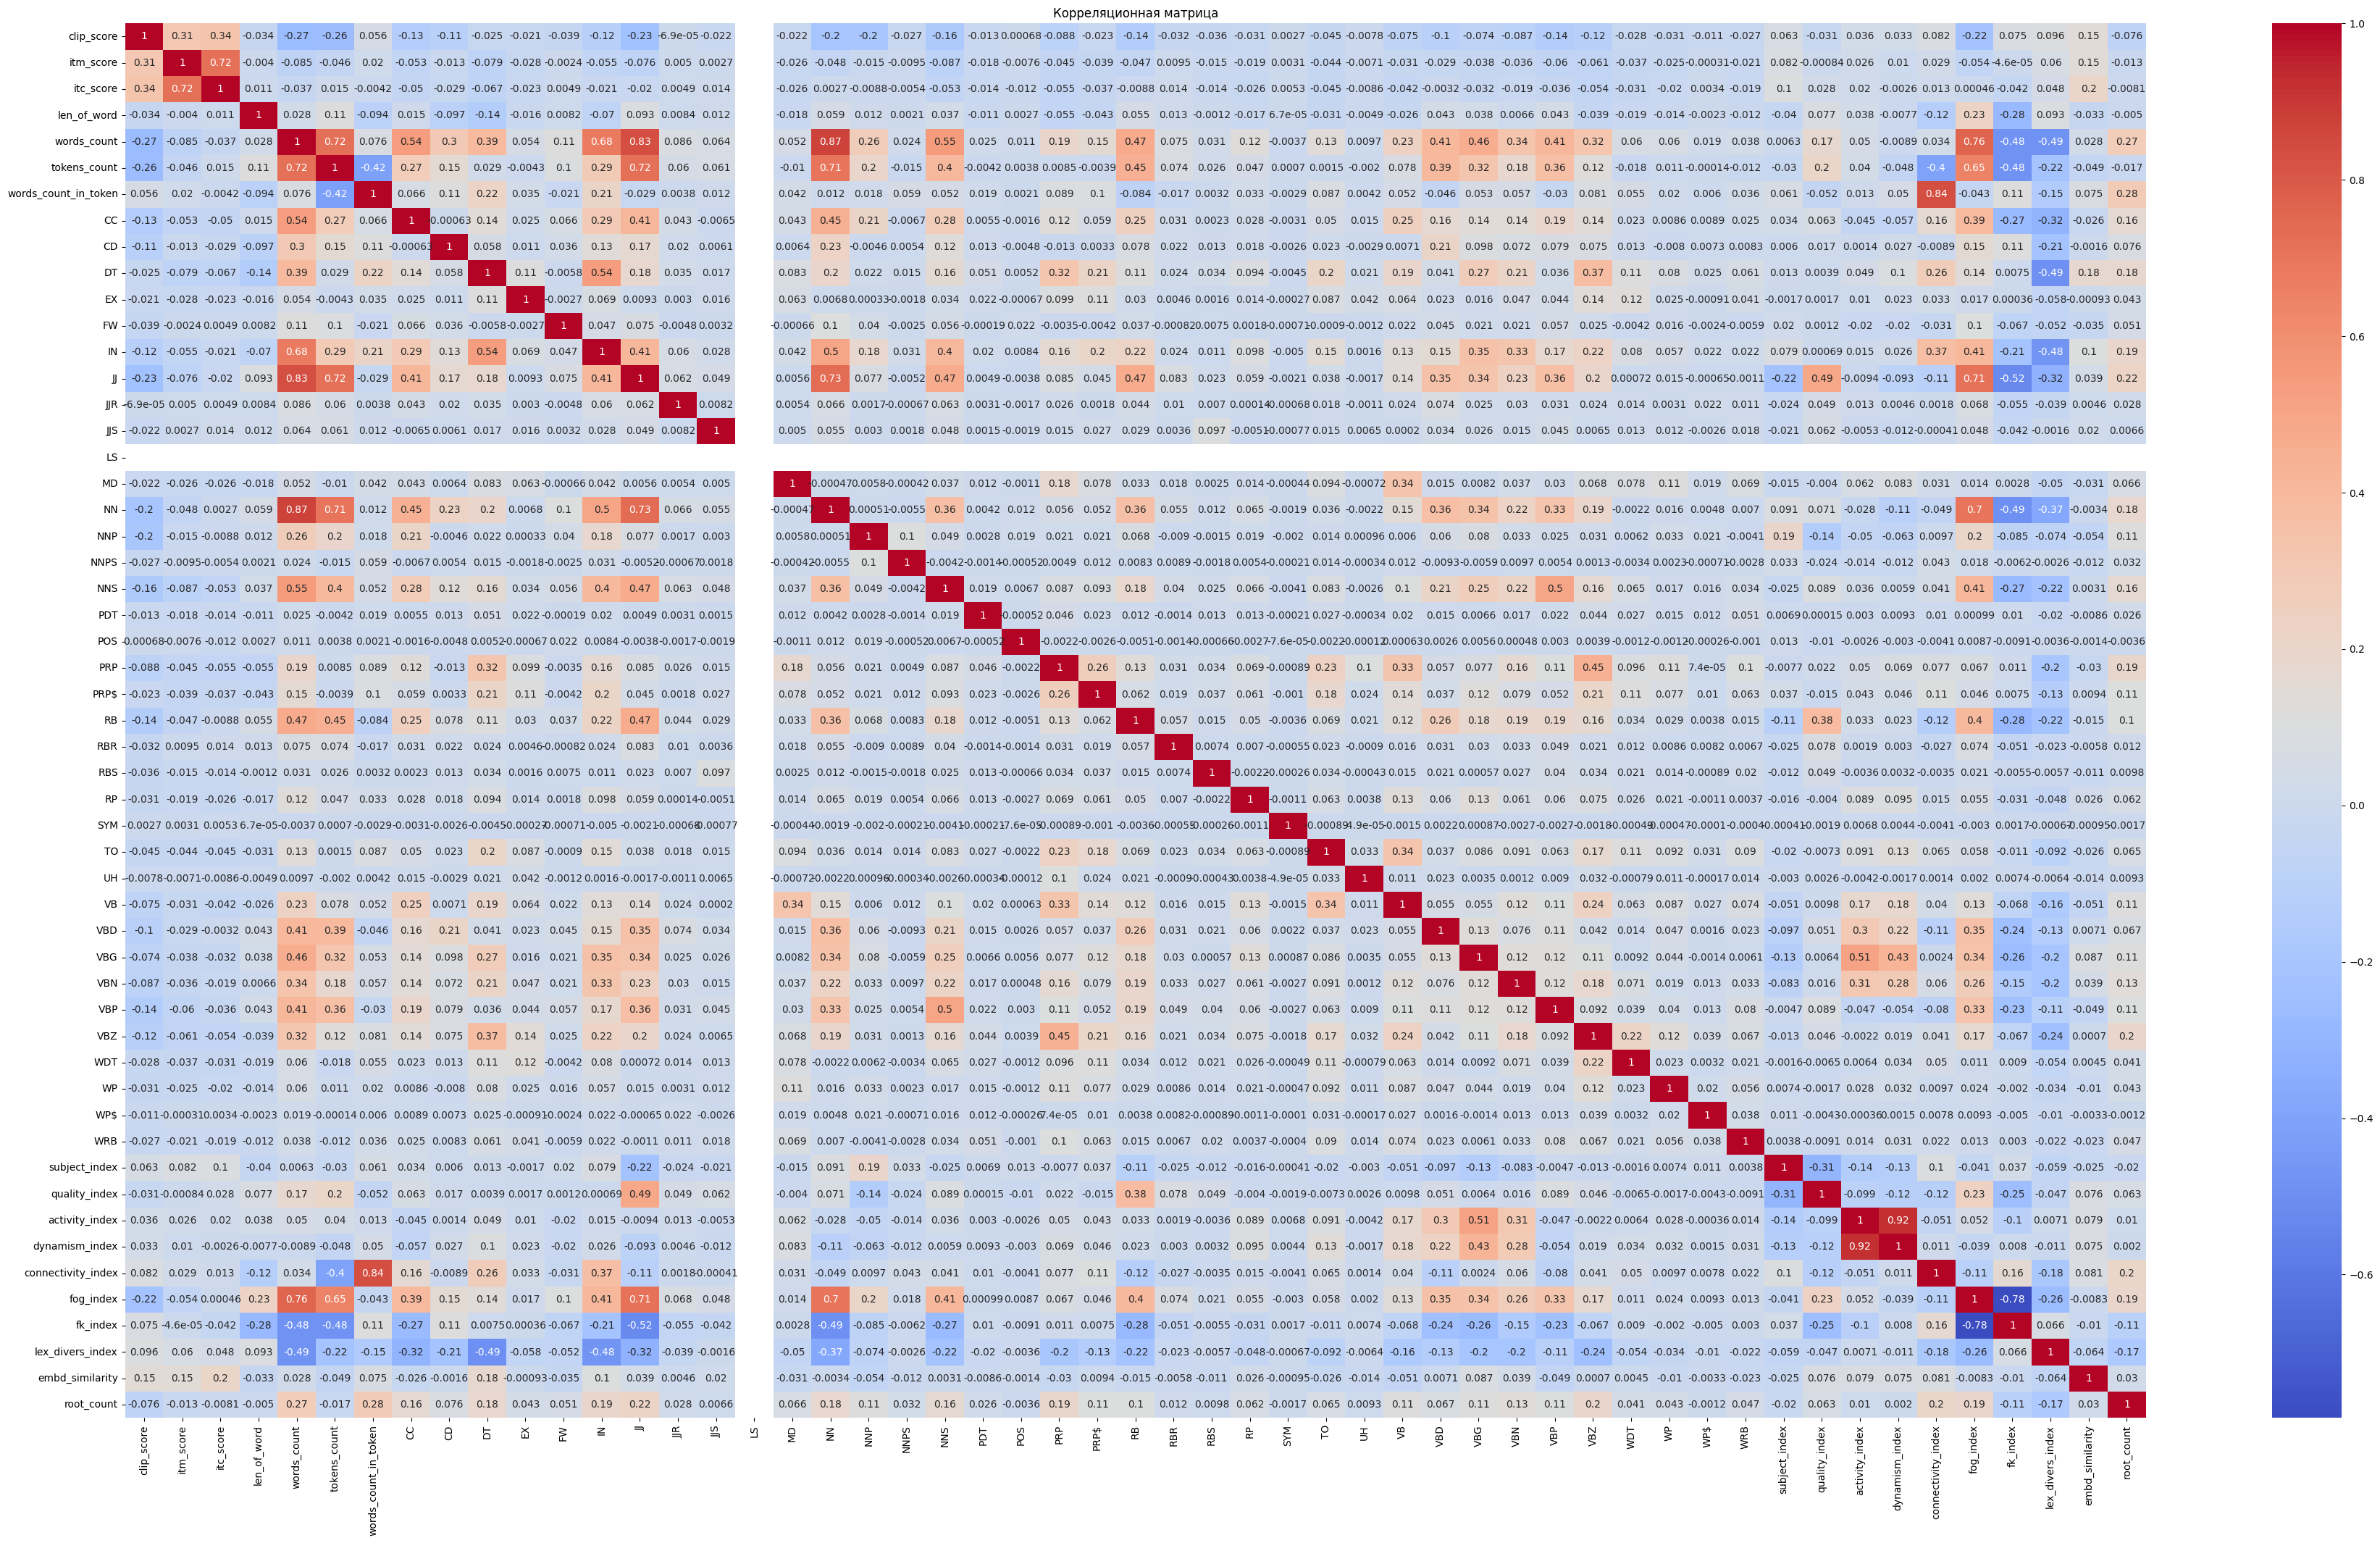

In [65]:
plt.figure(figsize = (45,25))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

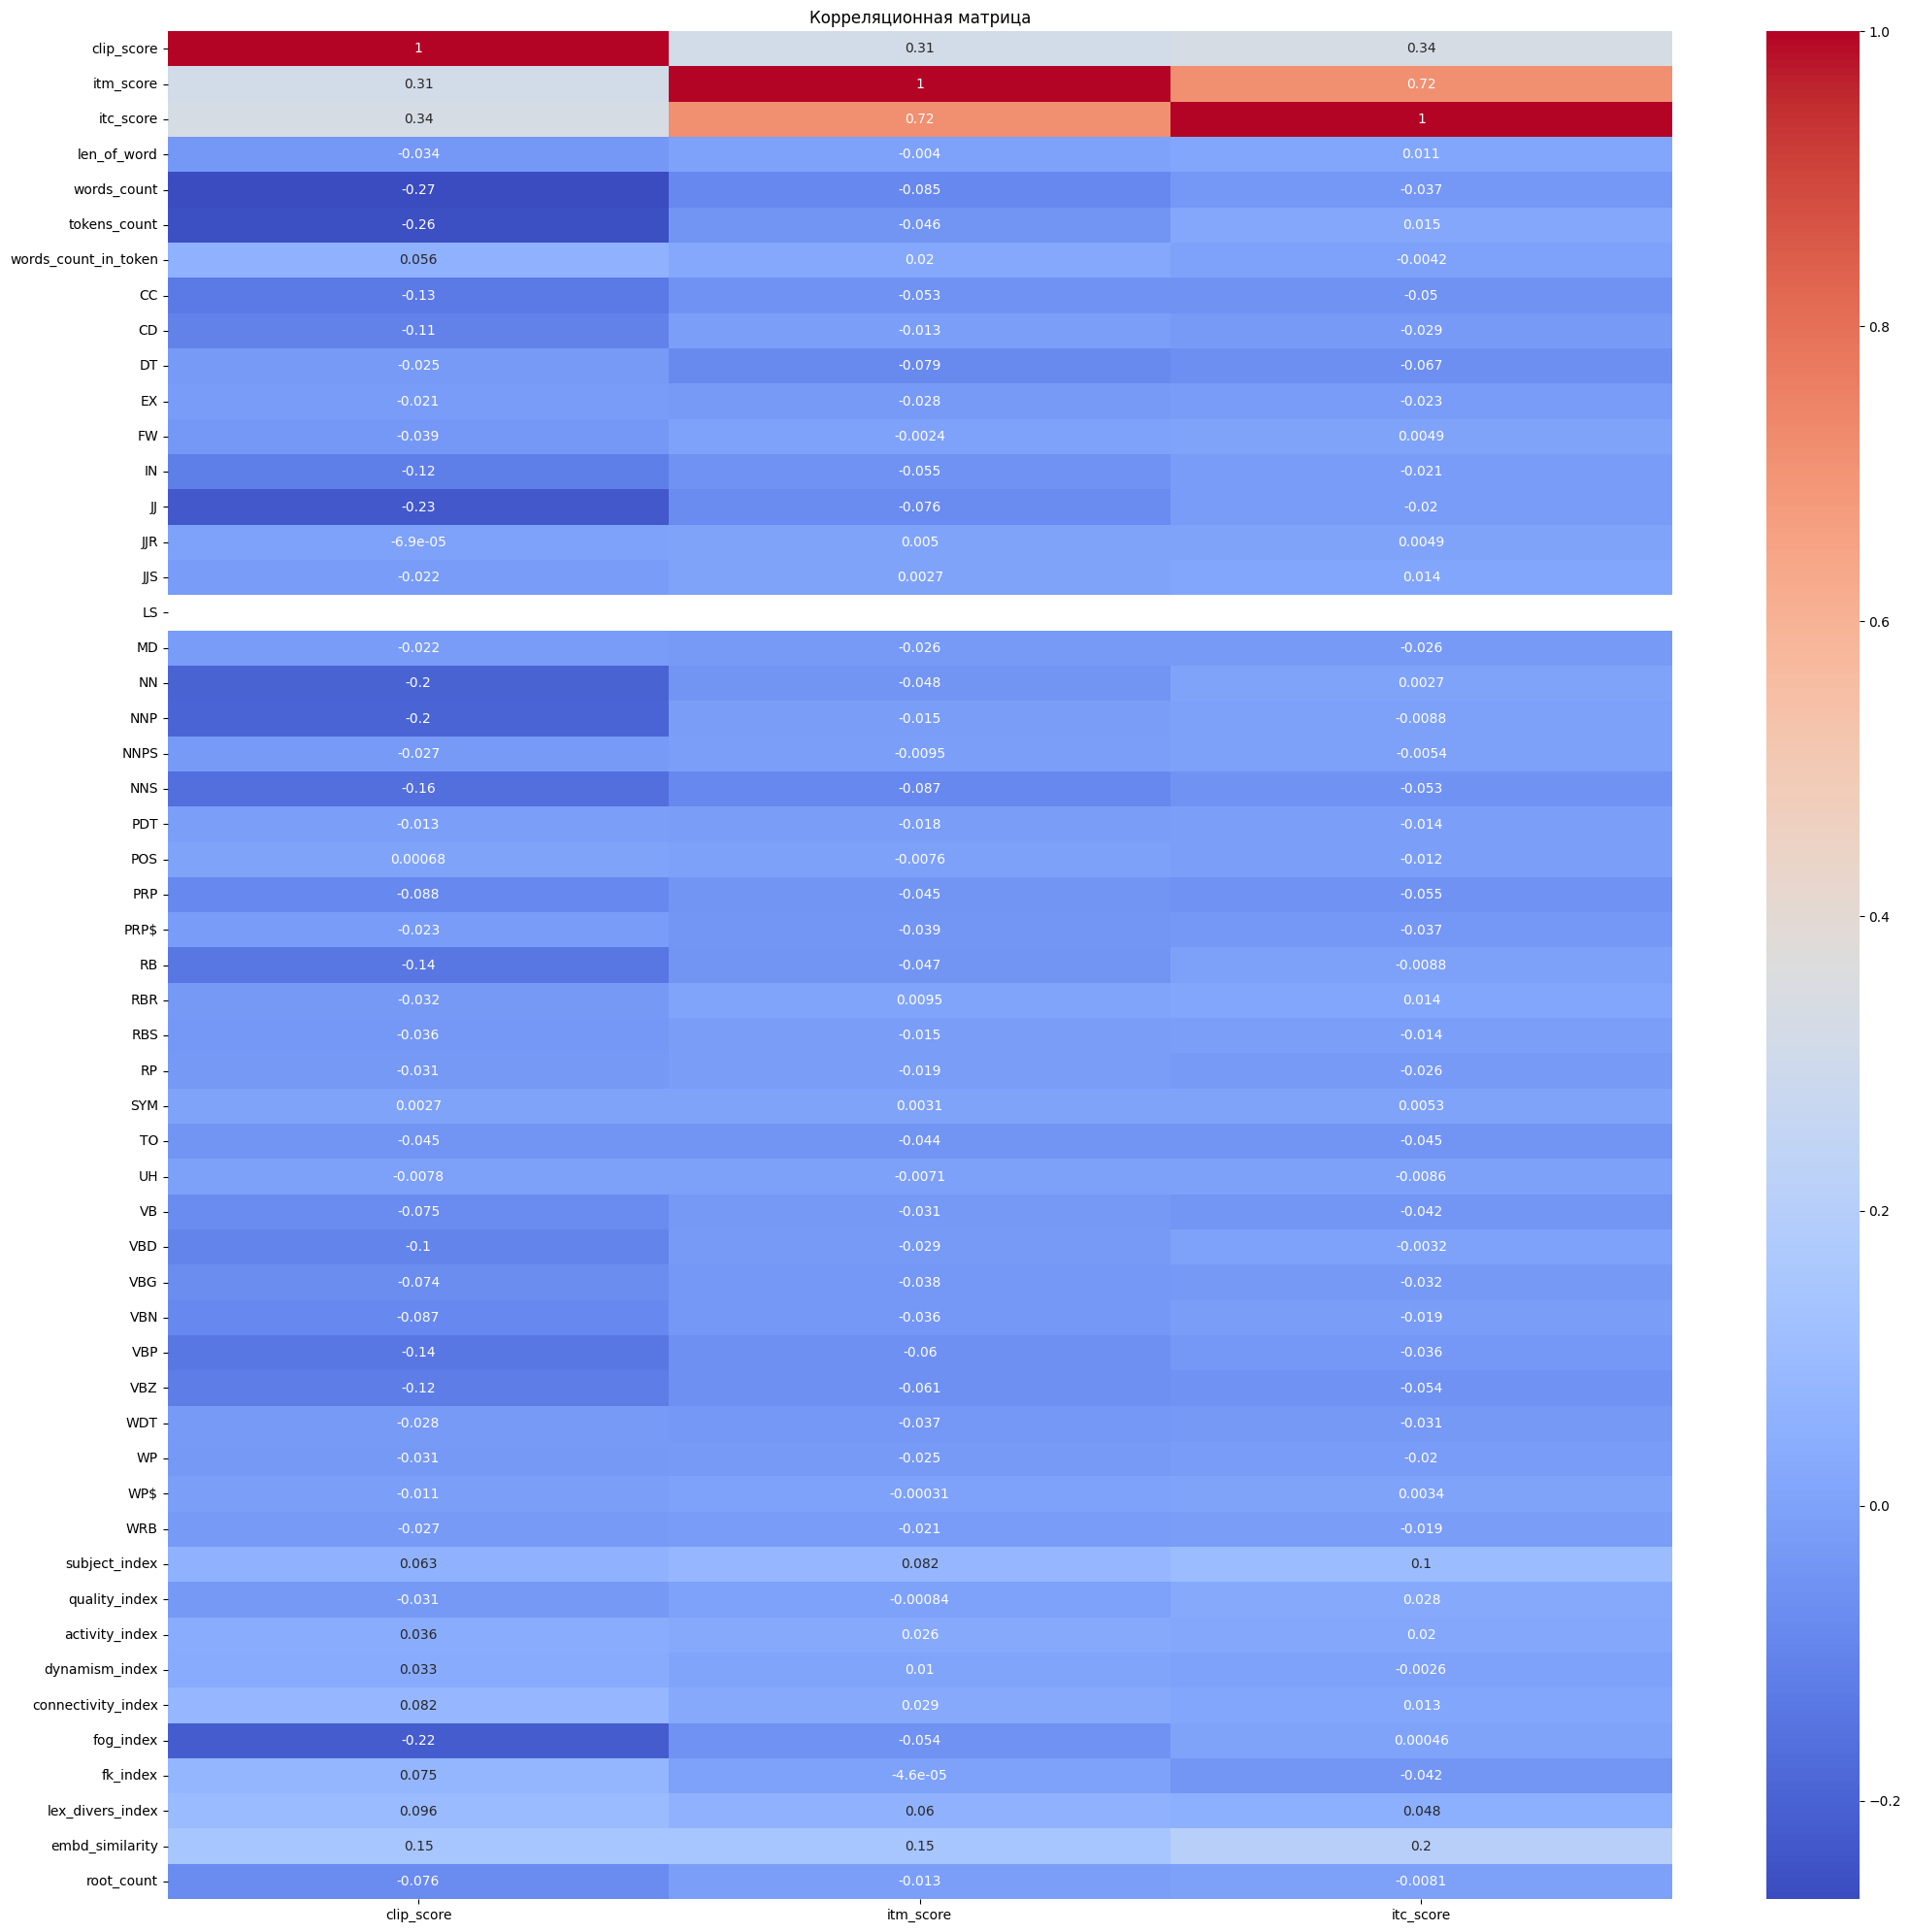

In [66]:
plt.figure(figsize = (25,25))
ax = sns.heatmap(correlation_matrix[['clip_score', 'itm_score', 'itc_score']], annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

# Статистическое описание и построение графиков

В ячейках ниже было получено статистическое описание для признака "Количество основ в промпте" и построены соответствующие графики

In [220]:
df[df['root_count'] <= 10]['root_count'].describe()

count    99878.000000
mean         1.325167
std          1.031879
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: root_count, dtype: float64

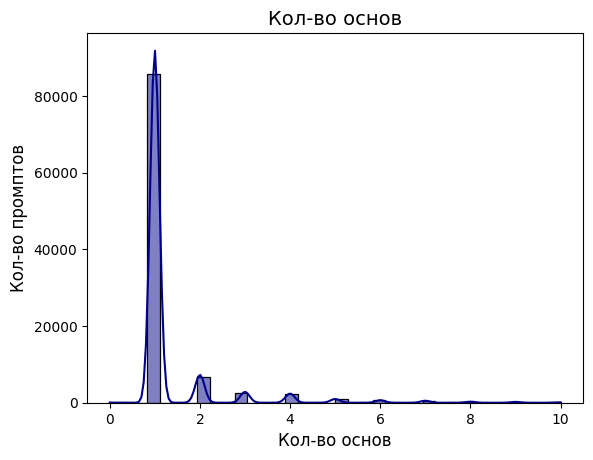

In [221]:
sns.histplot(df[df['root_count'] <= 10]['root_count'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во основ", fontsize=14)
plt.xlabel("Кол-во основ", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Количество существительных в промпте" и построены соответствующие графики

In [162]:
df['NOUN'] = df['NN'] + df['NNP'] + df['NNS'] + df['NNPS']

In [166]:
df[df['NOUN'] <= 100]['NOUN'].describe()

count    99994.000000
mean        11.708783
std          7.761039
min          0.000000
25%          5.000000
50%         10.000000
75%         17.000000
max         94.000000
Name: NOUN, dtype: float64

In [164]:
df[['clip_score', 'itm_score', 'itc_score', 'NOUN']].corr()

,clip_score,itm_score,itc_score,NOUN
clip_score,1.000000,0.313790,0.335704,-0.270888
itm_score,0.313790,1.000000,0.717568,-0.061521
itc_score,0.335704,0.717568,1.000000,-0.010249
NOUN,-0.270888,-0.061521,-0.010249,1.000000


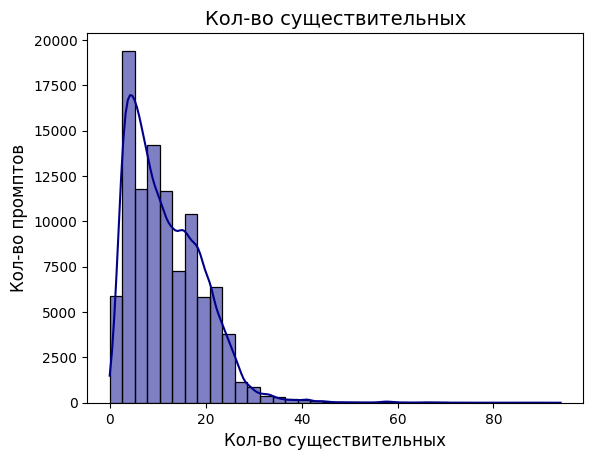

In [167]:
sns.histplot(df[df['NOUN'] <= 100]['NOUN'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во существительных", fontsize=14)
plt.xlabel("Кол-во существительных", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

Так как признак показал значимый уровень корреляции, был построен график зависимости распределения значений метрики CLIP-score от количества существительных

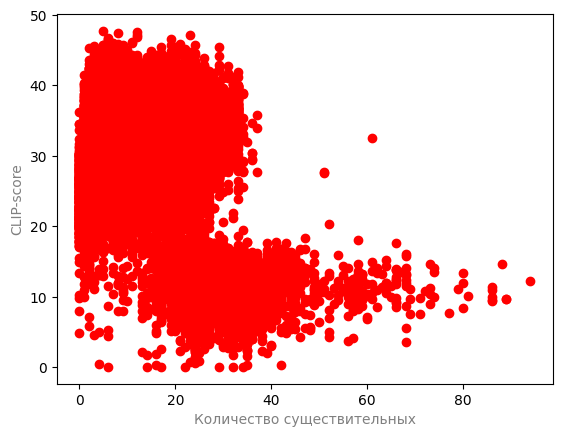

In [206]:
plt.xlabel('Количество существительных', color='gray')
plt.ylabel('CLIP-score',color='gray')
plt.plot(df[df['NOUN'] <= 100]['NOUN'],df[df['NOUN'] <= 100]['clip_score'],'ro')
plt.show()

Также с помощью U-критерия Манна — Уитни было выявлено наличие статистически значимой разницы между выборками промптов с < 30 существительных и >= 30 существительных

In [203]:
data1 = df[df['NOUN'] < 30]['clip_score']
data2 = df[df['NOUN'] >= 30]['clip_score']
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=156028201.500, p=0.000
Different distribution (reject H0)


В ячейках ниже было получено статистическое описание для признака "Количество глаголов в промпте" и построены соответствующие графики

In [169]:
df['VERB'] = df['VB'] + df['VBD'] + df['VBG'] + df['VBN']

In [170]:
df[df['VERB'] <= 100]['VERB'].describe()

count    100000.000000
mean          1.619160
std           1.594035
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          36.000000
Name: VERB, dtype: float64

In [171]:
df[['clip_score', 'itm_score', 'itc_score', 'VERB']].corr()

,clip_score,itm_score,itc_score,VERB
clip_score,1.000000,0.313790,0.335704,-0.140135
itm_score,0.313790,1.000000,0.717568,-0.057172
itc_score,0.335704,0.717568,1.000000,-0.038141
VERB,-0.140135,-0.057172,-0.038141,1.000000


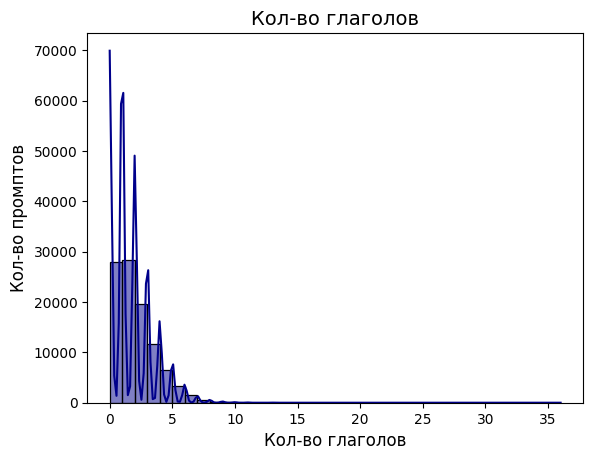

In [172]:
sns.histplot(df[df['VERB'] <= 100]['VERB'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во глаголов", fontsize=14)
plt.xlabel("Кол-во глаголов", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Количество прилагательных в промпте" и построены соответствующие графики

In [174]:
df['ADJ'] = df['JJ'] + df['JJR'] + df['JJS']

In [175]:
df[df['ADJ'] <= 100]['ADJ'].describe()

count    100000.000000
mean          4.520420
std           3.870317
min           0.000000
25%           1.000000
50%           4.000000
75%           7.000000
max          53.000000
Name: ADJ, dtype: float64

In [176]:
df[['clip_score', 'itm_score', 'itc_score', 'ADJ']].corr()

,clip_score,itm_score,itc_score,ADJ
clip_score,1.000000,0.313790,0.335704,-0.228026
itm_score,0.313790,1.000000,0.717568,-0.074856
itc_score,0.335704,0.717568,1.000000,-0.019426
ADJ,-0.228026,-0.074856,-0.019426,1.000000


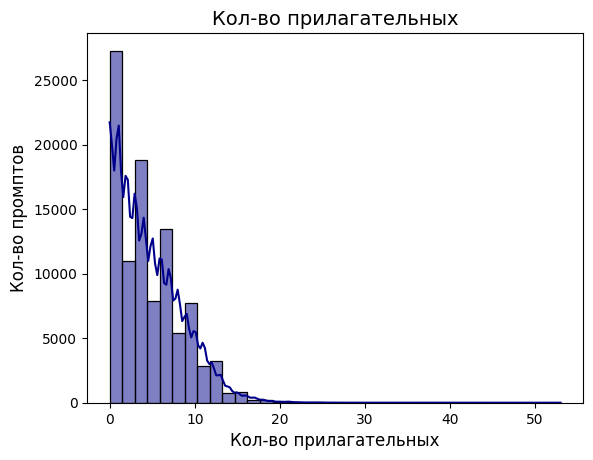

In [177]:
sns.histplot(df[df['ADJ'] <= 100]['ADJ'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во прилагательных", fontsize=14)
plt.xlabel("Кол-во прилагательных", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

Так как признак показал значимый уровень корреляции, был построен график зависимости распределения значений метрики CLIP-score от количества прилагательных

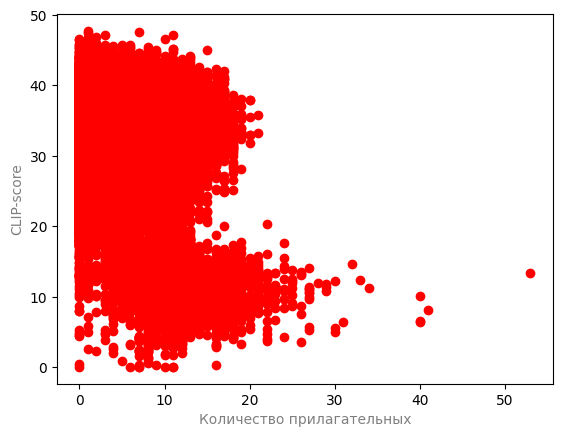

In [208]:
plt.xlabel('Количество прилагательных', color='gray')
plt.ylabel('CLIP-score',color='gray')
plt.plot(df[df['ADJ'] <= 100]['ADJ'],df[df['ADJ'] <= 100]['clip_score'],'ro')
plt.show()

Также с помощью U-критерия Манна — Уитни было выявлено наличие статистически значимой разницы между выборками промптов с < 20 прилагательных и >= 20 прилагательных

In [209]:
data1 = df[df['ADJ'] < 20]['clip_score']
data2 = df[df['ADJ'] >= 20]['clip_score']
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=17997513.500, p=0.000
Different distribution (reject H0)


В ячейках ниже было получено статистическое описание для признака "Количество наречий в промпте" и построены соответствующие графики

In [179]:
df['ADV'] = df['RB'] + df['RBR'] + df['RBS']

In [180]:
df[df['ADV'] <= 100]['ADV'].describe()

count    100000.000000
mean          0.611720
std           0.916377
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          22.000000
Name: ADV, dtype: float64

In [181]:
df[['clip_score', 'itm_score', 'itc_score', 'ADV']].corr()

,clip_score,itm_score,itc_score,ADV
clip_score,1.000000,0.313790,0.335704,-0.144805
itm_score,0.313790,1.000000,0.717568,-0.045723
itc_score,0.335704,0.717568,1.000000,-0.007874
ADV,-0.144805,-0.045723,-0.007874,1.000000


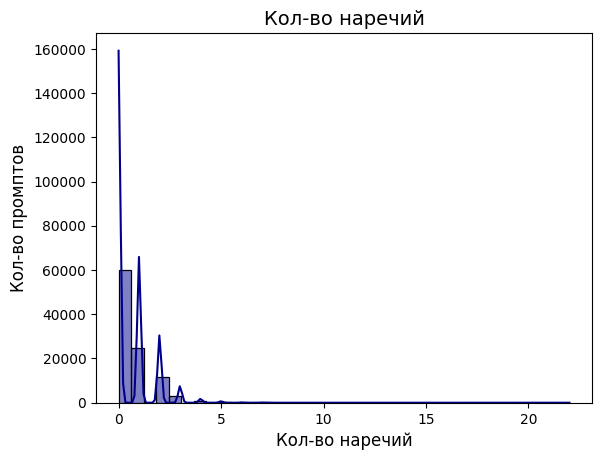

In [182]:
sns.histplot(df[df['ADV'] <= 100]['ADV'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во наречий", fontsize=14)
plt.xlabel("Кол-во наречий", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Количество предлогов в промпте" и построены соответствующие графики

In [184]:
df[df['IN'] <= 100]['IN'].describe()

count    100000.000000
mean          2.415630
std           1.912485
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          36.000000
Name: IN, dtype: float64

In [185]:
df[['clip_score', 'itm_score', 'itc_score', 'IN']].corr()

,clip_score,itm_score,itc_score,IN
clip_score,1.000000,0.313790,0.335704,-0.116036
itm_score,0.313790,1.000000,0.717568,-0.055179
itc_score,0.335704,0.717568,1.000000,-0.021490
IN,-0.116036,-0.055179,-0.021490,1.000000


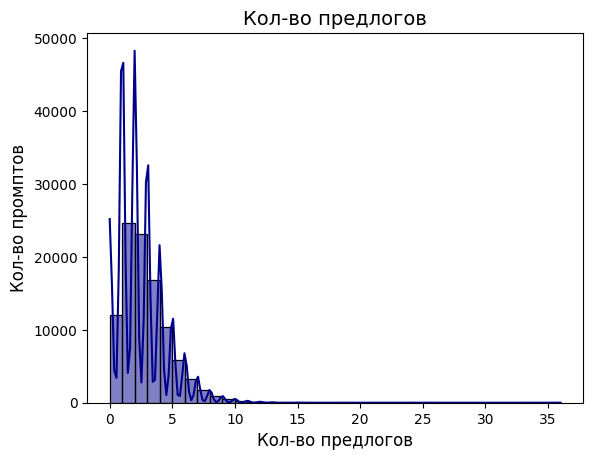

In [186]:
sns.histplot(df[df['IN'] <= 100]['IN'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во предлогов", fontsize=14)
plt.xlabel("Кол-во предлогов", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Количество местоимений в промпте" и построены соответствующие графики

In [188]:
df['PRONOUN'] = df['PRP'] + df['PRP$'] + df['WP'] + df['WP$']

In [189]:
df[df['PRONOUN'] <= 100]['PRONOUN'].describe()

count    100000.000000
mean          0.109360
std           0.484399
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          34.000000
Name: PRONOUN, dtype: float64

In [190]:
df[['clip_score', 'itm_score', 'itc_score', 'PRONOUN']].corr()

,clip_score,itm_score,itc_score,PRONOUN
clip_score,1.000000,0.313790,0.335704,-0.077752
itm_score,0.313790,1.000000,0.717568,-0.056188
itc_score,0.335704,0.717568,1.000000,-0.059796
PRONOUN,-0.077752,-0.056188,-0.059796,1.000000


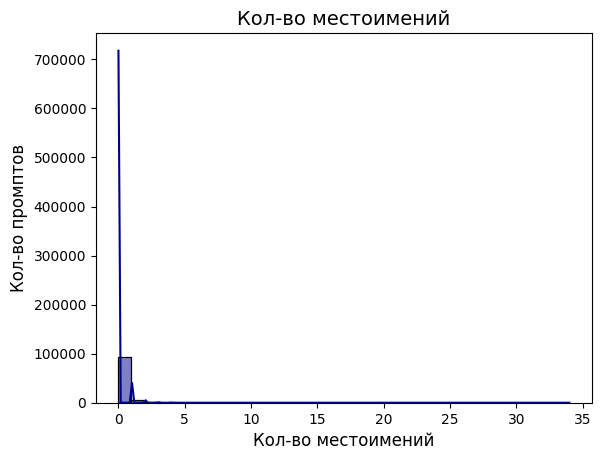

In [191]:
sns.histplot(df[df['PRONOUN'] <= 100]['PRONOUN'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во местоимений", fontsize=14)
plt.xlabel("Кол-во местоимений", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Количество союзов в промпте" и построены соответствующие графики

In [193]:
df[df['CC'] <= 100]['CC'].describe()

count    100000.000000
mean          0.665390
std           1.165101
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          18.000000
Name: CC, dtype: float64

In [194]:
df[['clip_score', 'itm_score', 'itc_score', 'CC']].corr()

,clip_score,itm_score,itc_score,CC
clip_score,1.000000,0.313790,0.335704,-0.133126
itm_score,0.313790,1.000000,0.717568,-0.052747
itc_score,0.335704,0.717568,1.000000,-0.050325
CC,-0.133126,-0.052747,-0.050325,1.000000


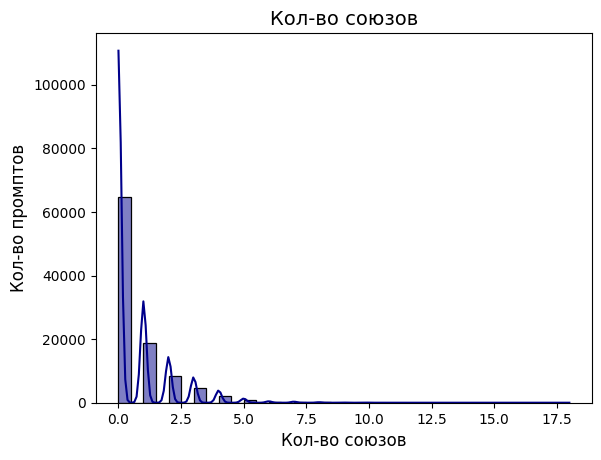

In [195]:
sns.histplot(df[df['CC'] <= 100]['CC'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во союзов", fontsize=14)
plt.xlabel("Кол-во союзов", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Количество междометий в промпте" и построены соответствующие графики

In [197]:
df[df['UH'] <= 100]['UH'].describe()

count    100000.000000
mean          0.000080
std           0.008944
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: UH, dtype: float64

In [198]:
df[['clip_score', 'itm_score', 'itc_score', 'UH']].corr()

,clip_score,itm_score,itc_score,UH
clip_score,1.000000,0.313790,0.335704,-0.007778
itm_score,0.313790,1.000000,0.717568,-0.007095
itc_score,0.335704,0.717568,1.000000,-0.008590
UH,-0.007778,-0.007095,-0.008590,1.000000


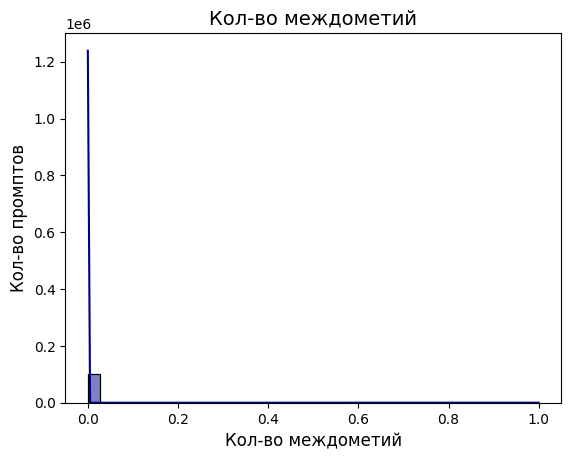

In [199]:
sns.histplot(df[df['UH'] <= 100]['UH'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во междометий", fontsize=14)
plt.xlabel("Кол-во междометий", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Средняя длина слова в промпте" и построены соответствующие графики

In [88]:
df.len_of_word.describe()

count    100000.000000
mean          5.340649
std           2.138247
min           0.000000
25%           4.800000
50%           5.363636
75%           5.857143
max         601.500000
Name: len_of_word, dtype: float64

In [101]:
df[df['len_of_word'] <= 20]['len_of_word'].describe()

count    99986.000000
mean         5.330569
std          0.913402
min          0.000000
25%          4.800000
50%          5.363636
75%          5.857143
max         18.000000
Name: len_of_word, dtype: float64

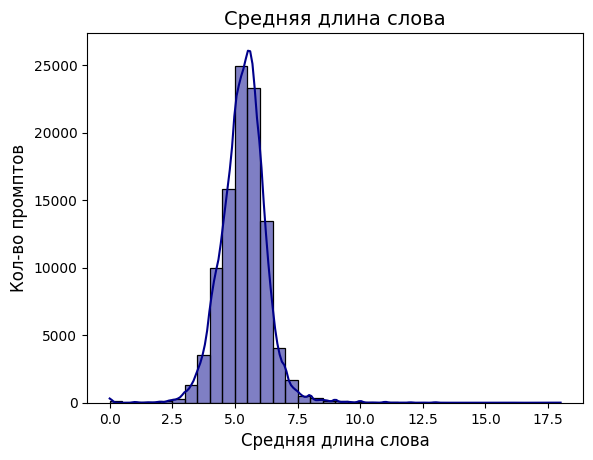

In [102]:
sns.histplot(df[df['len_of_word'] <= 20]['len_of_word'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Средняя длина слова", fontsize=14)
plt.xlabel("Средняя длина слова", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Индекс предметности" и построены соответствующие графики


In [106]:
df[df['subject_index'] <= 10]['subject_index'].describe()

count    99424.000000
mean         2.134787
std          1.555486
min          0.000000
25%          1.250000
50%          1.800000
75%          2.666667
max         10.000000
Name: subject_index, dtype: float64

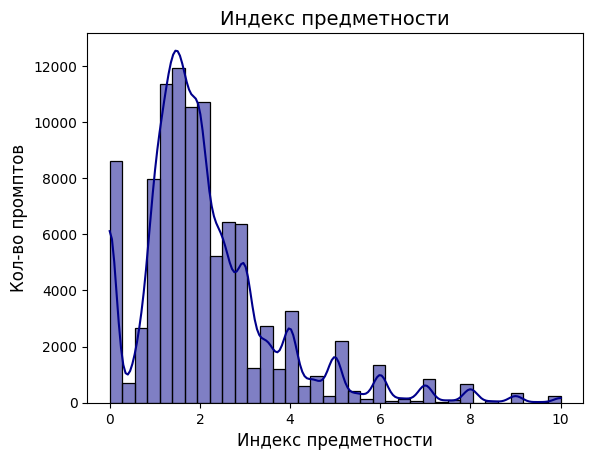

In [107]:
sns.histplot(df[df['subject_index'] <= 10]['subject_index'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Индекс предметности", fontsize=14)
plt.xlabel("Индекс предметности", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Индекс качественности" и построены соответствующие графики

In [113]:
df[df['quality_index'] <= 2]['quality_index'].describe()

count    99864.000000
mean         0.375447
std          0.272904
min          0.000000
25%          0.200000
50%          0.333333
75%          0.500000
max          2.000000
Name: quality_index, dtype: float64

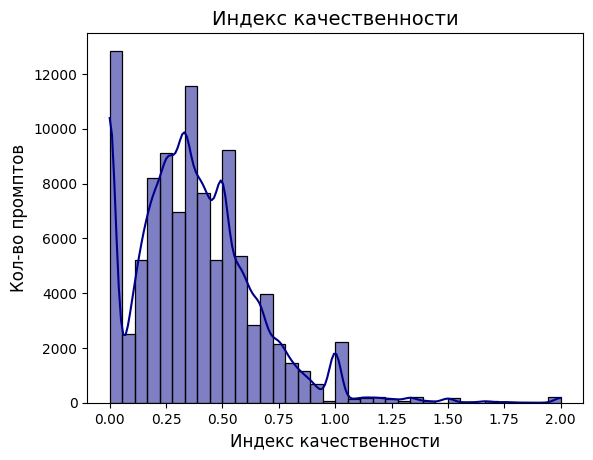

In [114]:
sns.histplot(df[df['quality_index'] <= 2]['quality_index'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Индекс качественности", fontsize=14)
plt.xlabel("Индекс качественности", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Индекс активности" и построены соответствующие графики

In [115]:
df.activity_index.describe()

count    100000.000000
mean          0.064743
std           0.061499
min           0.000000
25%           0.000000
50%           0.057692
75%           0.100000
max           1.000000
Name: activity_index, dtype: float64

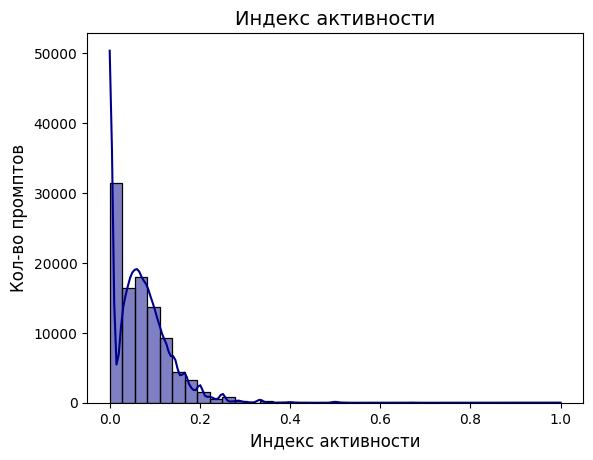

In [116]:
sns.histplot(df[df['activity_index'] <= 1]['activity_index'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Индекс активности", fontsize=14)
plt.xlabel("Индекс активности", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Индекс динамизма" и построены соответствующие графики

In [119]:
df[df['dynamism_index'] <= 1]['dynamism_index'].describe()

count    99965.000000
mean         0.107383
std          0.117348
min          0.000000
25%          0.000000
50%          0.083333
75%          0.157895
max          1.000000
Name: dynamism_index, dtype: float64

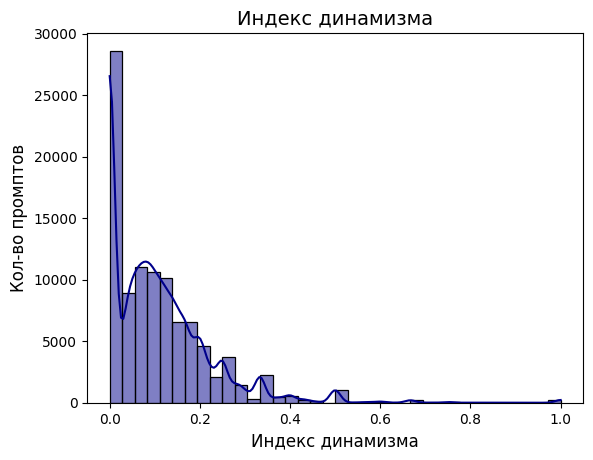

In [120]:
sns.histplot(df[df['dynamism_index'] <= 1]['dynamism_index'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Индекс динамизма", fontsize=14)
plt.xlabel("Индекс динамизма", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Индекс связанности" и построены соответствующие графики

In [123]:
df[df['connectivity_index'] <= 10]['connectivity_index'].describe()

count    99958.000000
mean         0.851593
std          1.033310
min          0.000000
25%          0.235294
50%          0.500000
75%          1.000000
max         10.000000
Name: connectivity_index, dtype: float64

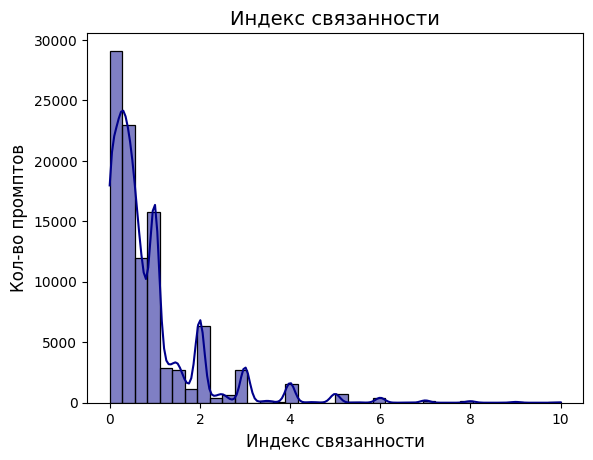

In [124]:
sns.histplot(df[df['connectivity_index'] <= 10]['connectivity_index'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Индекс связанности", fontsize=14)
plt.xlabel("Индекс связанности", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Косинусная мера сходства семантических векторов" и построены соответствующие графики

In [126]:
df[df['embd_similarity'] >= 0]['embd_similarity'].describe()

count    99745.000000
mean         0.389968
std          0.150810
min          0.000055
25%          0.283935
50%          0.385395
75%          0.493215
max          0.967252
Name: embd_similarity, dtype: float64

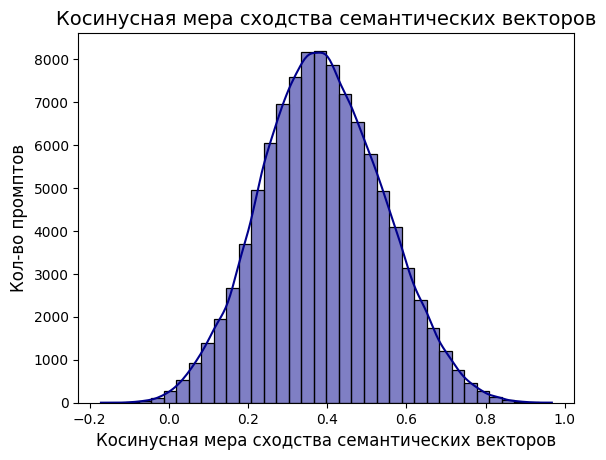

In [127]:
sns.histplot(df[df['embd_similarity'] >= -1]['embd_similarity'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Косинусная мера сходства семантических векторов", fontsize=14)
plt.xlabel("Косинусная мера сходства семантических векторов", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Длина промпта" и построены соответствующие графики

In [132]:
df[df['words_count'] <= 100]['words_count'].describe()

count    99886.000000
mean        24.137276
std         15.091364
min          0.000000
25%         12.000000
50%         22.000000
75%         35.000000
max        100.000000
Name: words_count, dtype: float64

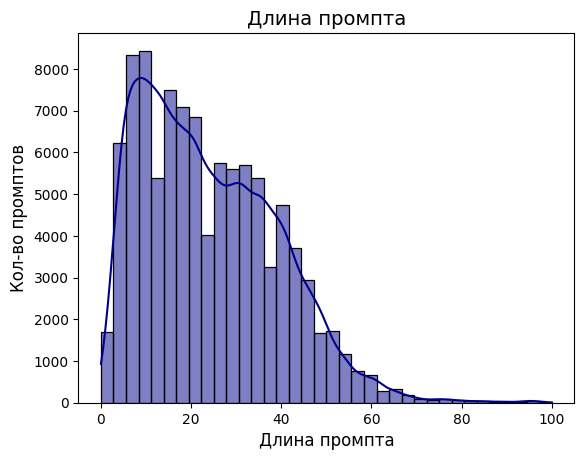

In [130]:
sns.histplot(df[df['words_count'] <= 100]['words_count'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Длина промпта", fontsize=14)
plt.xlabel("Длина промпта", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

Так как признак показал значимый уровень корреляции, был построен график зависимости распределения значений метрики CLIP-score от длины промпта

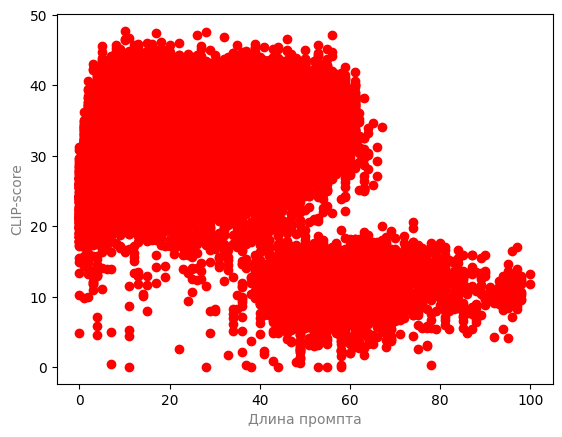

In [214]:
plt.xlabel('Длина промпта', color='gray')
plt.ylabel('CLIP-score',color='gray')
plt.plot(df[df['words_count'] <= 100]['words_count'], df[df['words_count'] <= 100]['clip_score'],'ro')
plt.show()

Также с помощью U-критерия Манна — Уитни было выявлено наличие статистически значимой разницы между выборками промптов с длиной < 60 и >= 60

In [243]:
data1 = df[df['words_count'] < 60]['clip_score']
data2 = df[df['words_count'] >= 60]['clip_score']
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=170395068.500, p=0.000
Different distribution (reject H0)


В ячейках ниже было получено статистическое описание для признака "Кол-во токенов в промпте" и построены соответствующие графики

In [134]:
df[df['tokens_count'] <= 50]['tokens_count'].describe()

count    99985.000000
mean         6.302015
std          5.366572
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max         49.000000
Name: tokens_count, dtype: float64

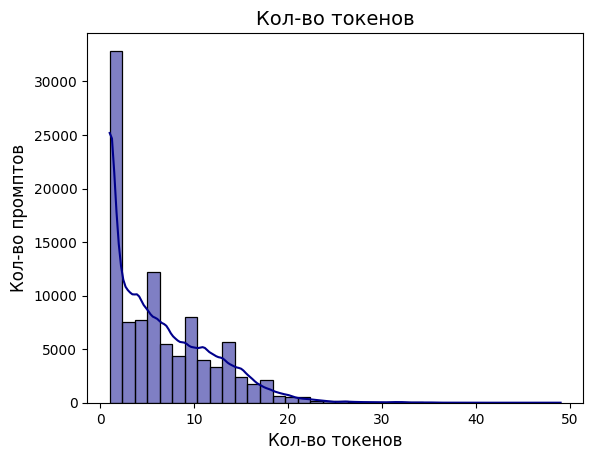

In [135]:
sns.histplot(df[df['tokens_count'] <= 50]['tokens_count'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во токенов", fontsize=14)
plt.xlabel("Кол-во токенов", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

Так как признак показал значимый уровень корреляции, был построен график зависимости распределения значений метрики CLIP-score от кол-ва токенов в промпте

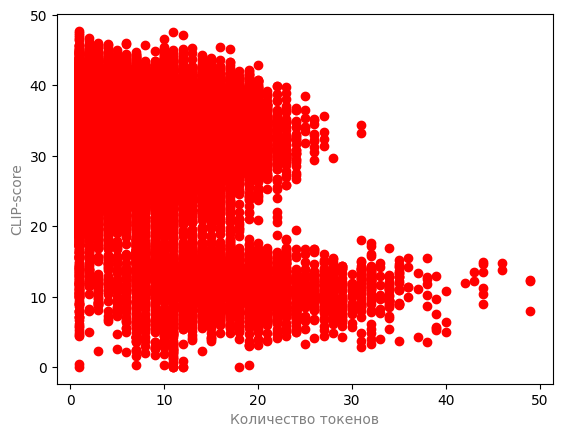

In [215]:
plt.xlabel('Количество токенов', color='gray')
plt.ylabel('CLIP-score',color='gray')
plt.plot(df[df['tokens_count'] <= 50]['tokens_count'], df[df['tokens_count'] <= 50]['clip_score'],'ro')
plt.show()

Также с помощью U-критерия Манна — Уитни было выявлено наличие статистически значимой разницы между выборками промптов с количеством токенов < 25 и >= 25

In [244]:
data1 = df[df['tokens_count'] < 25]['clip_score']
data2 = df[df['tokens_count'] >= 25]['clip_score']
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=47084965.500, p=0.000
Different distribution (reject H0)


В ячейках ниже было получено статистическое описание для признака "Кол-во слов в токене" и построены соответствующие графики

In [137]:
df[df['words_count_in_token'] <= 50]['words_count_in_token'].describe()

count    99861.000000
mean         5.922193
std          5.657913
min          0.000000
25%          2.818182
50%          4.000000
75%          7.000000
max         50.000000
Name: words_count_in_token, dtype: float64

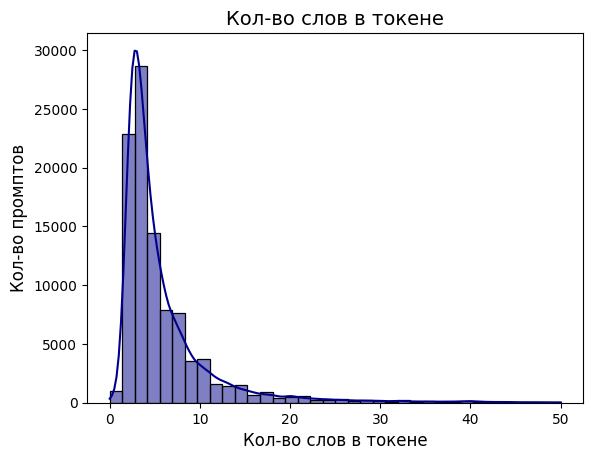

In [138]:
sns.histplot(df[df['words_count_in_token'] <= 50]['words_count_in_token'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Кол-во слов в токене", fontsize=14)
plt.xlabel("Кол-во слов в токене", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Индекс туманности Ганнинга" и построены соответствующие графики

In [140]:
df[df['fog_index'] <= 100]['fog_index'].describe()

count    99997.000000
mean        21.833813
std          8.643329
min          0.000000
25%         16.021053
50%         22.400000
75%         27.883871
max         99.057944
Name: fog_index, dtype: float64

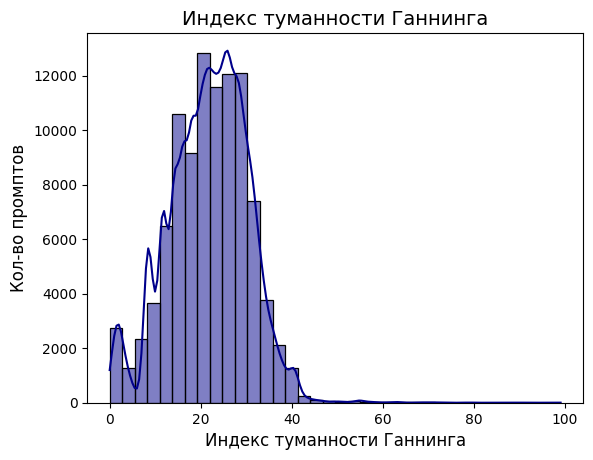

In [142]:
sns.histplot(df[df['fog_index'] <= 100]['fog_index'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Индекс туманности Ганнинга", fontsize=14)
plt.xlabel("Индекс туманности Ганнинга", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

Так как признак показал значимый уровень корреляции, был построен график зависимости распределения значений метрики CLIP-score от индекса туманности Ганнинга

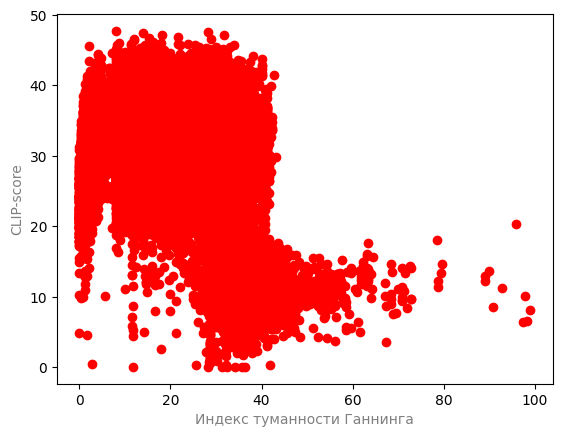

In [216]:
plt.xlabel('Индекс туманности Ганнинга', color='gray')
plt.ylabel('CLIP-score',color='gray')
plt.plot(df[df['fog_index'] <= 100]['fog_index'], df[df['fog_index'] <= 100]['clip_score'],'ro')
plt.show()

Также с помощью U-критерия Манна — Уитни было выявлено наличие статистически значимой разницы между выборками промптов с индексом туманности Ганнинга < 40 и >= 40

In [245]:
data1 = df[df['fog_index'] < 40]['clip_score']
data2 = df[df['fog_index'] >= 40]['clip_score']
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=119682391.000, p=0.000
Different distribution (reject H0)


В ячейках ниже было получено статистическое описание для признака "Индекс Флеша-Кинкейда" и построены соответствующие графики

In [144]:
df[df['fk_index'] <= 100]['fk_index'].describe()

count    98369.000000
mean        20.881521
std         24.519042
min          0.000000
25%          0.000000
50%         11.130000
75%         35.945000
max         99.905000
Name: fk_index, dtype: float64

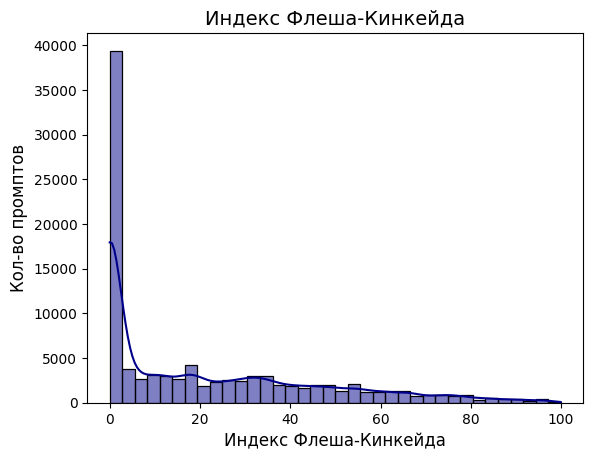

In [145]:
sns.histplot(df[df['fk_index'] <= 100]['fk_index'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Индекс Флеша-Кинкейда", fontsize=14)
plt.xlabel("Индекс Флеша-Кинкейда", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "Коэффициент лексического разнообразия" и построены соответствующие графики

In [ ]:
df[df['lex_divers_index'] <= 100]['lex_divers_index'].describe()

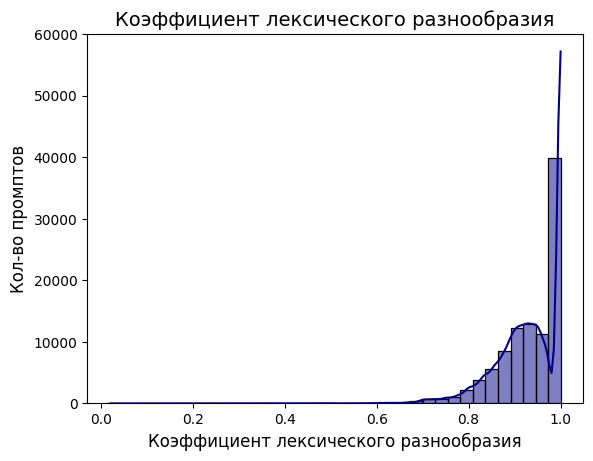

In [147]:
sns.histplot(df['lex_divers_index'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("Коэффициент лексического разнообразия", fontsize=14)
plt.xlabel("Коэффициент лексического разнообразия", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "CLIP-score" и построены соответствующие графики

In [151]:
df.clip_score.describe()

count    100000.000000
mean         31.878229
std           5.762747
min           0.000000
25%          29.940451
50%          32.672613
75%          35.242193
max          47.739197
Name: clip_score, dtype: float64

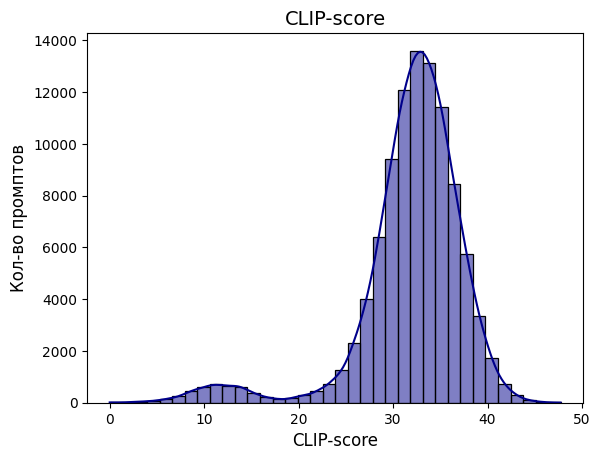

In [152]:
sns.histplot(df['clip_score'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("CLIP-score", fontsize=14)
plt.xlabel("CLIP-score", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "BLIP-ITM-score" и построены соответствующие графики

In [153]:
df.itm_score.describe()

count    1.000000e+05
mean     8.161991e-01
std      3.001245e-01
min      4.754037e-07
25%      7.818599e-01
50%      9.808675e-01
75%      9.985932e-01
max      9.999957e-01
Name: itm_score, dtype: float64

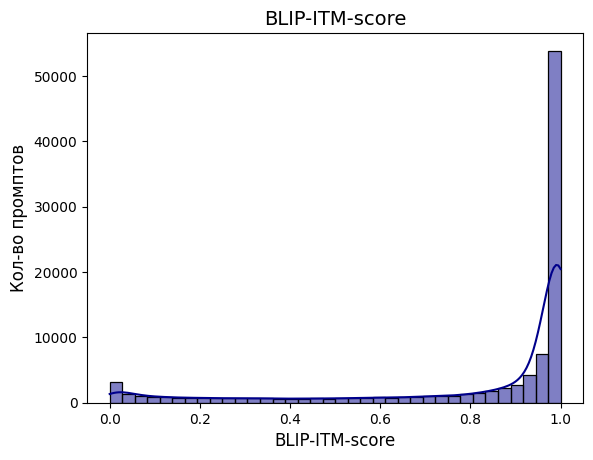

In [155]:
sns.histplot(df['itm_score'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("BLIP-ITM-score", fontsize=14)
plt.xlabel("BLIP-ITM-score", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()

В ячейках ниже было получено статистическое описание для признака "BLIP-ITC-score" и построены соответствующие графики

In [154]:
df.itc_score.describe()

count    100000.000000
mean          0.405644
std           0.055464
min           0.076978
25%           0.379278
50%           0.413664
75%           0.442291
max           0.583220
Name: itc_score, dtype: float64

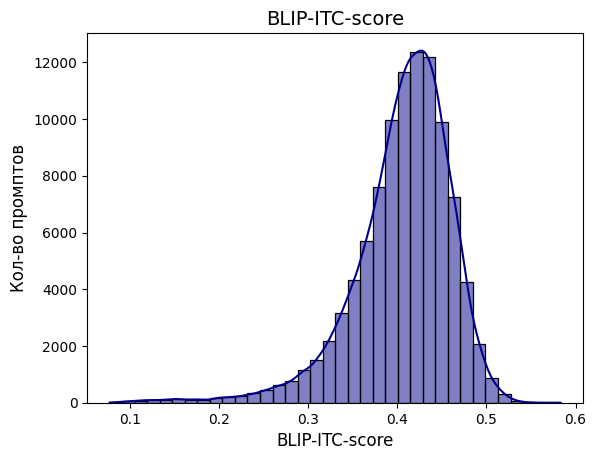

In [156]:
sns.histplot(df['itc_score'], kde=True, bins=int(180/5), color = 'darkblue', edgecolor = 'black')

plt.title("BLIP-ITC-score", fontsize=14)
plt.xlabel("BLIP-ITC-score", fontsize=12)
plt.ylabel("Кол-во промптов", fontsize=12)

plt.show()